In [1]:
sample = "LL835-LF-TC_S6"
template = "Tigre_2022_v2"
data_path = "/storage/wangshouwenLab/shared_folder/packages/snakemake_DARLIN/large_test/test_10X/LL835-LF-TC_S6"
output_dir = "/storage/wangshouwenLab/shared_folder/packages/snakemake_DARLIN/large_test/test_10X/output"

ref_dir ='/storage/wangshouwenLab/shared_folder/packages/snakemake_DARLIN/reference'
CARLIN_read_cutoff=3 # used to compare with CARLIN pipeline
cfg="sc10xV3" # ['sc10xV3',  'scCamellia']
min_reads_per_allele_group=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
distance_relative_threshold=0.03 # 5% error rate, will be multipled with the sequence length
read_ratio_threshold=0.6
seq_3prime_upper_N=15
seq_5prime_upper_N=None

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from mosaiclineage import DARLIN as dar
from mosaiclineage import larry
import importlib
importlib.reload(dar)
importlib.reload(larry)
#%config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows',20)
%matplotlib inline


if template.startswith("cCARLIN"):
    seq_5prime = dar.CA_5prime
    seq_3prime = dar.CA_3prime
    ref_DARLIN_seq = dar.CA_CARLIN
elif template.startswith("Tigre"):
    seq_5prime = dar.TA_5prime
    seq_3prime = dar.TA_3prime
    ref_DARLIN_seq = dar.TA_CARLIN
elif template.startswith("Rosa"):
    seq_5prime = dar.RA_5prime
    seq_3prime = dar.RA_3prime
    ref_DARLIN_seq = dar.RA_CARLIN
else:
    raise ValueError("template must start with {'cCARLIN','Tigre','Rosa'}")

/home/wangshouwenLab/wangshouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# Single-cell CARLIN pipeline for 10x data

In [3]:
CARLIN_dir=data_path+f'/DARLIN/results_cutoff_override_{CARLIN_read_cutoff}'

In [4]:
ref_name=cfg
df_ref_BC=pd.read_csv(f'{ref_dir}/{ref_name}_barcodes.txt.gz',
                      sep='\t',header=None,names=['CB'],compression='gzip')

In [5]:
%%time
## load sequences
df_raw_reads=dar.CARLIN_raw_reads(data_path,sample,protocol=cfg)

1131815it [00:36, 31340.71it/s]
1131815it [00:14, 75797.79it/s]


CPU times: user 2min 32s, sys: 2.6 s, total: 2min 34s
Wall time: 2min 35s


In [6]:
df_N=df_raw_reads[df_raw_reads['cell_bc'].apply(lambda x: 'N' in x)]
print('N fraction:',len(df_N)/len(df_raw_reads))

N fraction: 0.3125890715355425


In [8]:
df_filter_reads=dar.CARLIN_preprocessing(df_raw_reads,template=template,ref_cell_barcodes=df_ref_BC['CB'],
                                         seq_3prime_upper_N=seq_3prime_upper_N,seq_5prime_upper_N=seq_5prime_upper_N)

Total fastq: 1131815
Fastq frac. with vaid 5 prime: 0.915
Fastq frac. with vaid 3 prime: 0.691
Fastq with valid barcodes: 510350 (0.451)
Fastq frac. with vaid 3 and 5 prime: 0.451
Edited fastq fraction: 0.779


## Check raw data qualities

Check raw data to decide the read cutoff. If we see a linear slope between read number per cell and clone number per cell, this is a signature of sequencing-error induced clonal diversity

In [9]:
#df_counts=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=2.5,cell_key="clone_id",)

Identified 3764 putative cell_id


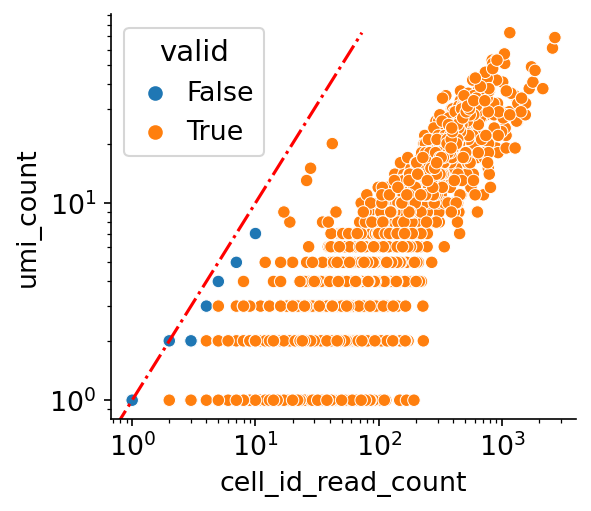

In [10]:
df_valid_cells=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=1.5,cell_key="cell_id",)

In [11]:
df_valid_cells

,cell_id,cell_id_read_count,umi_count,valid
0,LL835-LF-TC_S6_AAACGAAAGGAGTACC,981,29,True
1,LL835-LF-TC_S6_AAACGAATCTTACGTT,29,1,True
2,LL835-LF-TC_S6_AAACGCTGTAACATAG,44,2,True
3,LL835-LF-TC_S6_AAACGCTGTTTGTGGT,133,7,True
4,LL835-LF-TC_S6_AAACGCTTCGGTAACT,161,9,True
...,...,...,...,...
4213,LL835-LF-TC_S6_TTTGTTGGTTCCCACT,76,5,True
4214,LL835-LF-TC_S6_TTTGTTGTCCTGCCAT,131,3,True
4215,LL835-LF-TC_S6_TTTGTTGTCGAAACAA,25,3,True
4216,LL835-LF-TC_S6_TTTGTTGTCGTCCATC,20,1,True


In [12]:
#df_read=larry.QC_read_per_molecule(df_filter_reads,target_keys=["umi"])

We are interested to see at what read cutoff the corresponding cell number or clone number conform to our expectation. For example, for scCamellia, we only expect around 386cells, and ~300 clones

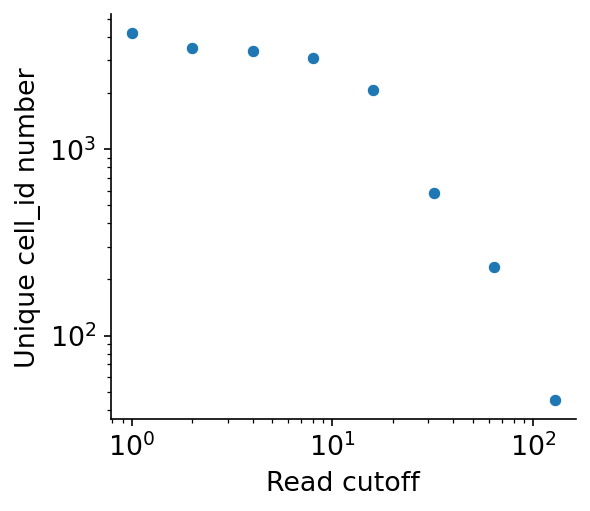

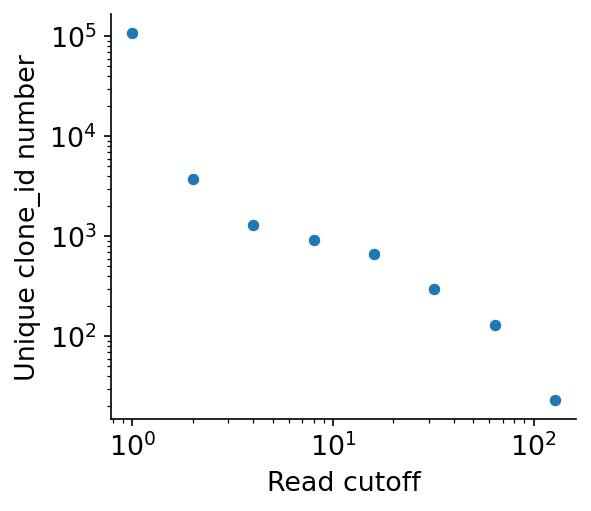

In [13]:
df_unique=larry.QC_unique_cells(df_filter_reads,target_keys=['cell_id','clone_id'])

In [14]:
larry.print_statistics(df_filter_reads)

library number: 1
cell_id number: 4218
clone_id number: 108834
umi_id number: 26296
total reads: 510K


Plot distribution of unique clone barcode length. This informs how computationally expensive the following operation will be

Text(0.5, 1.0, 'Raw CARLIN length dist (UMI): 235862 count')

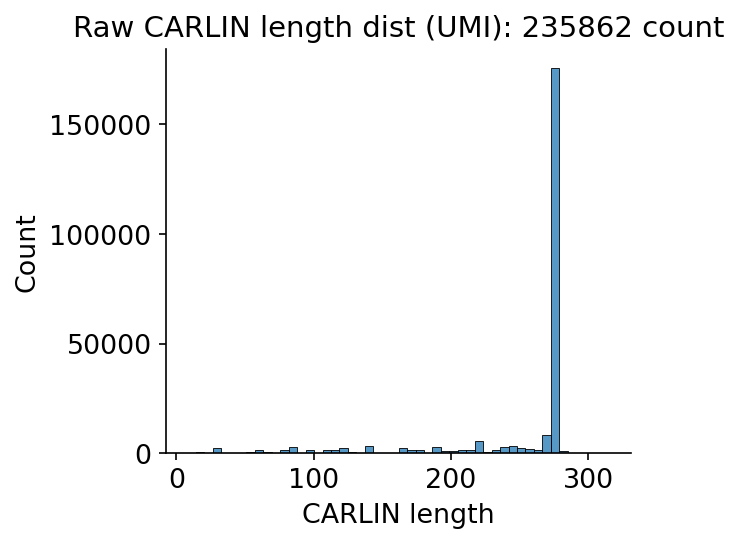

In [15]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=df_filter_reads['bc_length'] #list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=50)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Raw CARLIN length dist (UMI): {len(unique_bc_length)} count')

Text(0.5, 1.0, 'Unique CARLIN length dist: 250 count')

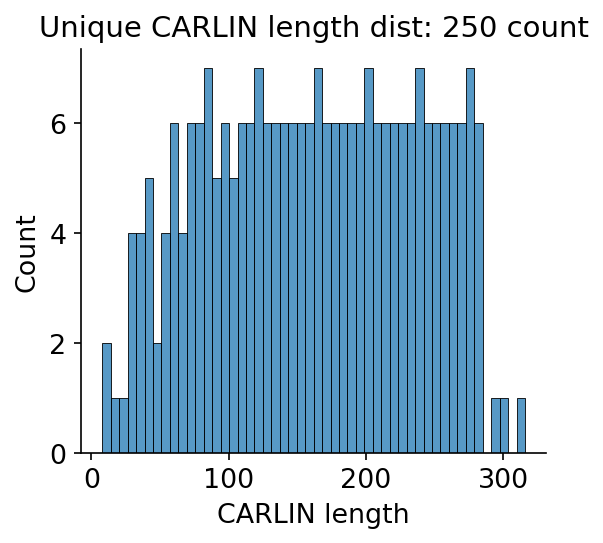

In [16]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=50)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Unique CARLIN length dist: {len(unique_bc_length)} count')

Denoise the clone id per each clone barcode length

We first perform barcode cleaning within a certian distance, then re-calculate the read number, and filter out low-read-count sequences. The read threshold is determined as the 10% of the max read count within each sequence length group, with a lower bound at min_reads_per_allele_group

## Collapse clone_id and filter cells within the same clone_id length

In [17]:
read_cutoff=3 # initial read count filtering 
# min_reads_per_allele_group=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
# distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
    
df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        read_cutoff=read_cutoff,
        denoise_method="UMI_tools",  # UMI_tools, 'Hamming'
        distance_threshold=1, #np.max([1,int(target_length*distance_relative_threshold)]),  
        whiteList=None,
        plot_report=False,
        progress_bar=False)

    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_HQ_group['bc_length']=target_length
    df_list.append(df_HQ_group)
df_denoise_bc_0=pd.concat(df_list)

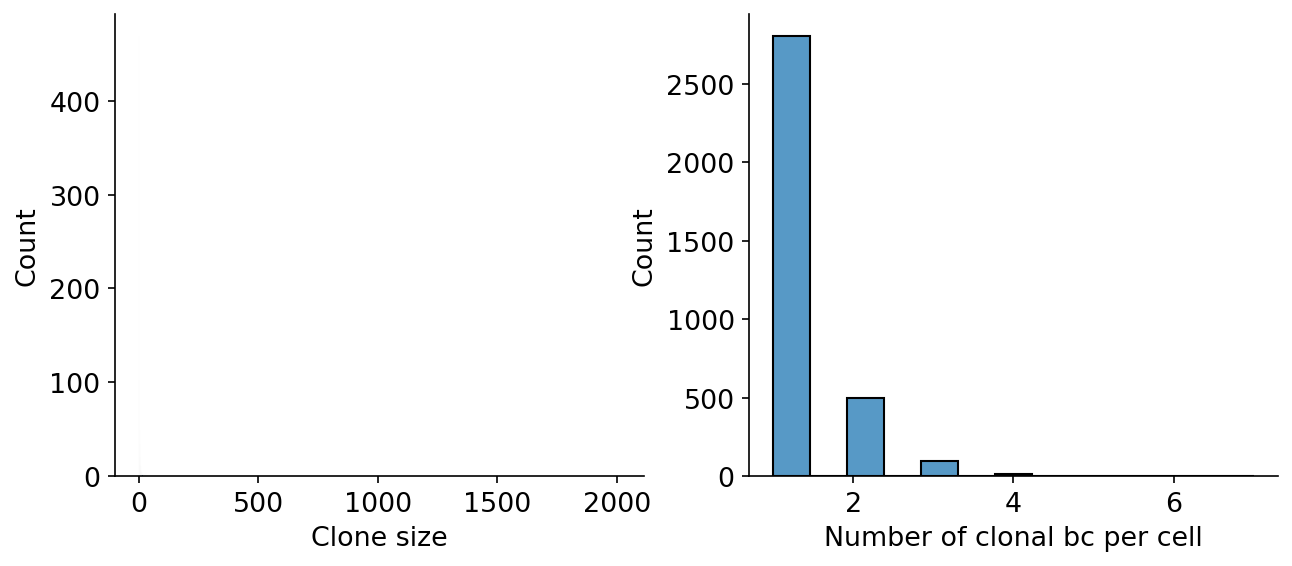

In [18]:
larry.QC_clonal_reports(df_denoise_bc_0)

In [19]:
larry.print_statistics(df_denoise_bc_0)

library number: 1
cell_id number: 3416
clone_id number: 749
total reads: 285K


In [20]:
# use a low-filtering threshold, and also avoid filtering out valid_cell ids from above
def filter_low_read_cells_per_clone(df):
    coarse_grained_readcutoff=np.max([min_reads_per_allele_group,0.01*df['read'].max()])
    #return df[(df['read']>=coarse_grained_readcutoff) | df['cell_id'].isin(df_valid_cells['cell_id'].unique())]
    return df[(df['read']>=coarse_grained_readcutoff) ]

df_denoise_bc_1=df_denoise_bc_0.groupby('clone_id',group_keys=True).apply(filter_low_read_cells_per_clone).reset_index(drop=True)
#df_out=df_HQ_group
    

In [21]:
larry.print_statistics(df_denoise_bc_1)

library number: 1
cell_id number: 3300
clone_id number: 722
total reads: 284K


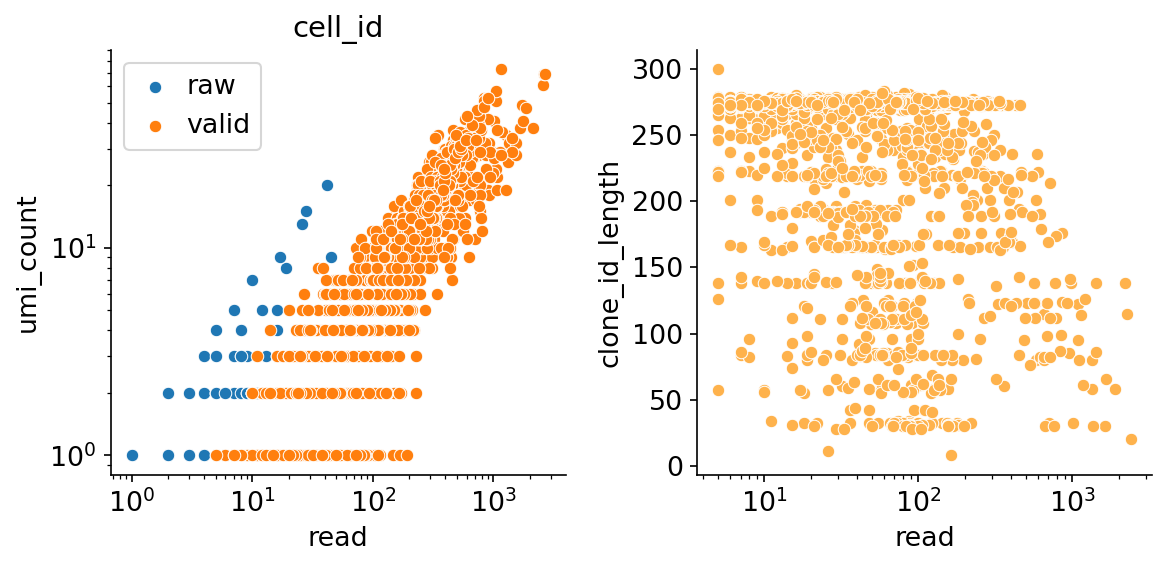

In [22]:
larry.QC_report_for_inferred_clones(df_filter_reads,df_denoise_bc_1)

## Select dominant clone_id within each cell_id

The above operation leaves some cell barcodes to have multiple clone barcodes. We select the read-dominant clonal barcodes as the putative clone id for each cell barcode.

In [23]:
# Obtain the dominant barcode in each cell
df_denoise_bc_2=larry.calculate_read_fraction_per_clone_cell(df_denoise_bc_1,norm_mode='max') # norm_mode: 'max', or 'sum'
df_final=df_denoise_bc_2[df_denoise_bc_2['cell_read_fraction']>0.99]

<Axes: xlabel='cell_read_fraction', ylabel='clone_read_fraction'>

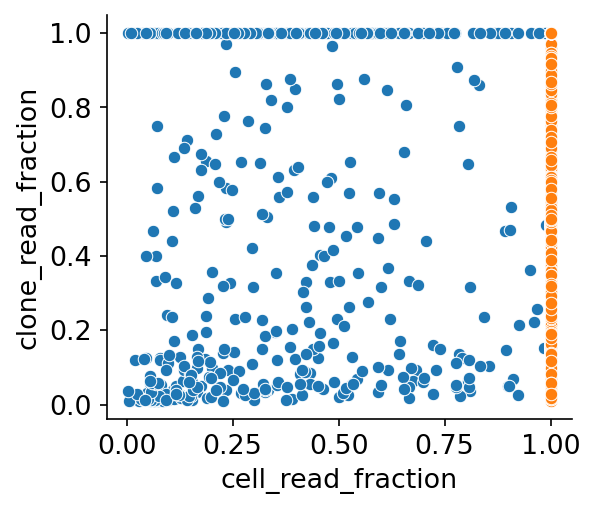

In [24]:
sns.scatterplot(data=df_denoise_bc_2,x='cell_read_fraction',y='clone_read_fraction')
sns.scatterplot(data=df_final,x='cell_read_fraction',y='clone_read_fraction')
#sns.scatterplot(data=df_output.merge(df_final,on=['cell_id','clone_id']),x='cell_read_fraction',y='clone_read_fraction',color='orange')
# plt.yscale('log')
# plt.xscale('log')

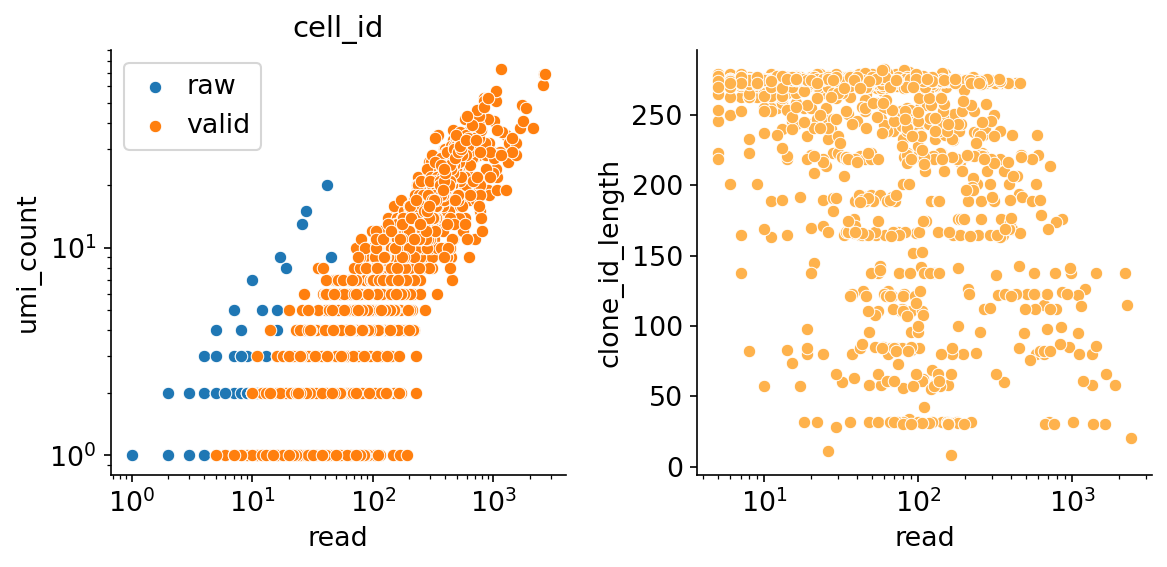

In [25]:
larry.QC_report_for_inferred_clones(df_filter_reads,df_final)

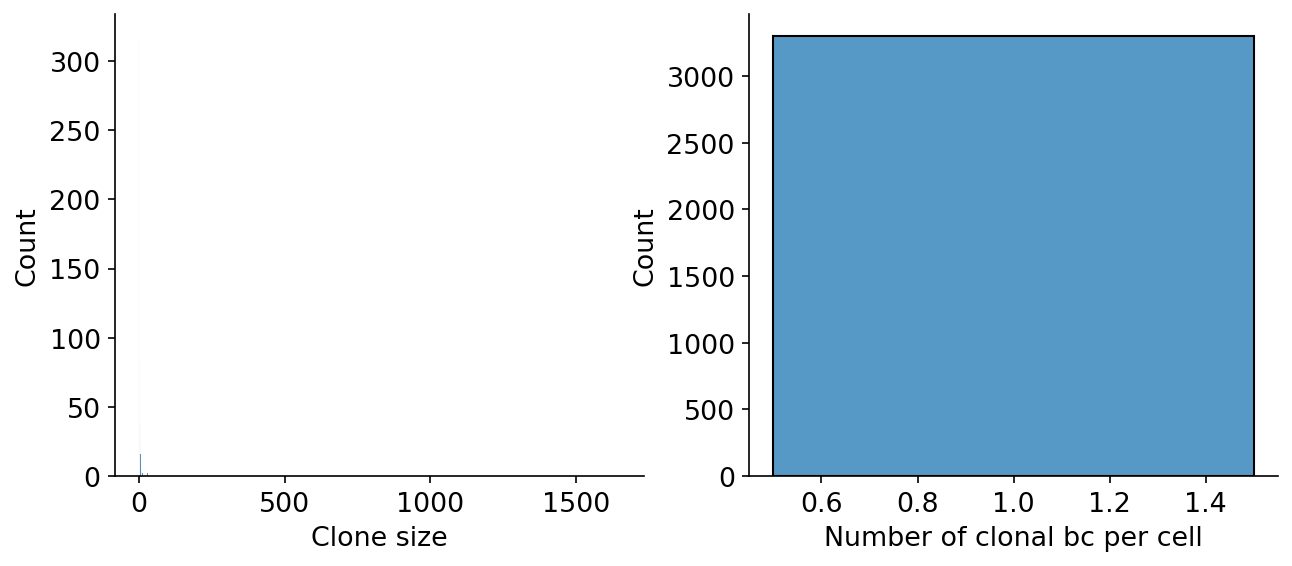

In [26]:
larry.QC_clonal_reports(df_final)

In [27]:
larry.print_statistics(df_final)

library number: 1
cell_id number: 3300
clone_id number: 543
total reads: 265K


In [28]:
df_final.sort_values('bc_length')

,library,cell_id,cell_bc,clone_id,read,umi_count,bc_length,clone_id_length,total_read_per_cell,total_read_per_clone,cell_read_fraction,clone_read_fraction
4,LL835-LF-TC_S6,LL835-LF-TC_S6_AGGGTGATCGTCGACG,AGGGTGATCGTCGACG,TCGCCGGA,163,3,8,8,163,163,1.0,1.000000
3,LL835-LF-TC_S6,LL835-LF-TC_S6_TACCTGCAGCAACTCT,TACCTGCAGCAACTCT,TCGACTATGGA,26,1,11,11,26,26,1.0,1.000000
1806,LL835-LF-TC_S6,LL835-LF-TC_S6_ATCTTCATCCATTCGC,ATCTTCATCCATTCGC,TCGCCGGAGTCGACTATGGA,2422,33,20,20,2422,2422,1.0,1.000000
3266,LL835-LF-TC_S6,LL835-LF-TC_S6_CTCGAGGCACCGTCGA,CTCGAGGCACCGTCGA,TCGCCGGAGTCGAGACGCTGACTATGGA,29,1,28,28,29,29,1.0,1.000000
2293,LL835-LF-TC_S6,LL835-LF-TC_S6_ATGGAGGGTACTAAGA,ATGGAGGGTACTAAGA,TCGCCGGAGTCGAGACGCTGACGCTATGGA,80,1,30,30,80,1625,1.0,0.049231
...,...,...,...,...,...,...,...,...,...,...,...,...
3678,LL835-LF-TC_S6,LL835-LF-TC_S6_ATTACCTAGTTCAACC,ATTACCTAGTTCAACC,TCGCCGGAGTCGAGACGCTGACGATATGGAGTCGACACGACTCGCG...,63,6,280,280,63,63,1.0,1.000000
2246,LL835-LF-TC_S6,LL835-LF-TC_S6_CGCATGGCAGCTACTA,CGCATGGCAGCTACTA,TCGCCGGAGTCGAGACGCTGACGAGGCCGATATGGAGTCGACACGA...,87,9,281,281,87,87,1.0,1.000000
3761,LL835-LF-TC_S6,LL835-LF-TC_S6_TCGGGTGAGCACCCAC,TCGGGTGAGCACCCAC,TCGCCGGAGTCGAGACGCTGACGGGATATGGAGTCGACACGACTCG...,58,8,282,282,58,58,1.0,1.000000
3395,LL835-LF-TC_S6,LL835-LF-TC_S6_TGTCCCAAGCTTTGTG,TGTCCCAAGCTTTGTG,TCGCCGGAGTCGAGACGCTGACGATATGGAGTCGACACGACTCGCG...,81,7,282,282,81,81,1.0,1.000000


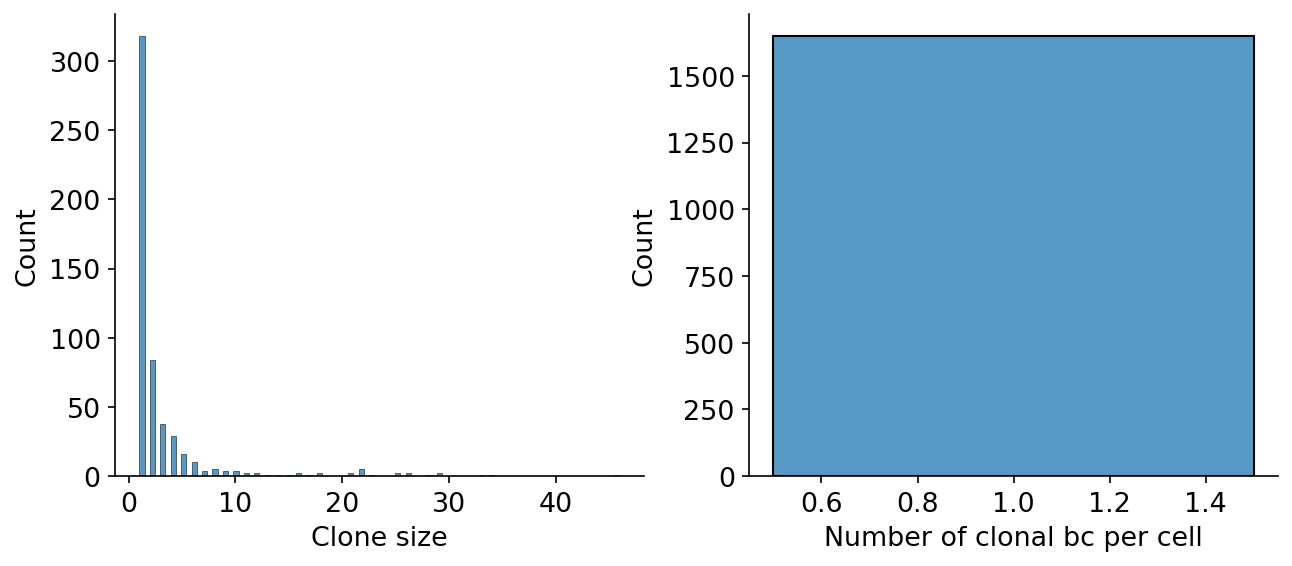

In [39]:
larry.QC_clonal_reports(df_final[~(df_final['clone_id']==ref_DARLIN_seq)])

In [40]:
df_final=dar.check_editing(df_final,template)
print('Editing efficiency:', df_final['edited'].mean())

Editing efficiency: 0.49696969696969695


In [ ]:
df_final.to_csv(f'{output_dir}/called_barcodes_by_SW_method.csv',index=0)
df_filter_reads.to_csv(f'{output_dir}/df_filter_reads_by_SW_method.csv',index=0)

In [ ]:
# df_plot=df_filter_reads[df_filter_reads['clone_id'].isin(df_final['clone_id'].unique())]
# sns.histplot(df_plot['read'],log_scale=True)

## Compare with CARLIN pipeline

In [35]:
compare_with_CARLIN_pipeline=False
if compare_with_CARLIN_pipeline:
    df_ref=dar.extract_CARLIN_info(CARLIN_dir,[sample])
    
    us_unique=set(df_final['clone_id'])
    orig_pipeline_unique=set(df_ref['CARLIN'])
    BC_insersect=us_unique.intersection(orig_pipeline_unique)
    print(f'Dected unique clones by our method: {len(us_unique)}; by CARLIN pipeline: {len(orig_pipeline_unique)}; intersection: {len(BC_insersect)}')
    
    df_ref_flat=dar.CARLIN_output_to_cell_by_barcode_long_table(df_ref)
    df_ref_flat_new=df_ref_flat.merge(df_filter_reads,on=['cell_bc','clone_id']).groupby(
            ['cell_id','cell_bc','clone_id']).agg(read=('read','sum'),CARLIN_length=('bc_length','mean')).reset_index()
    df_ref_flat_new['method']='CARLIN_pipeline'
    
    df_joint=df_final.merge(df_ref_flat_new,on=['cell_id','cell_bc','clone_id'],how='inner').set_index('cell_id')
    df_ref_flat_new=df_ref_flat_new.set_index('cell_id')
    df_ref_flat_new.loc[df_joint.index,'read']=df_joint['read_x']
    df_ref_flat_new=df_ref_flat_new.reset_index()
    
    plt.subplots()
    plt.plot(df_final['read'],df_final['CARLIN_length'],'^b',label='Our method')
    plt.plot(df_ref_flat_new['read'],df_ref_flat_new['CARLIN_length'],'+r',label='CARLIN')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('read number')
    plt.ylabel('CARLIN sequence length')
    
    plt.subplots()
    df_plot=df_filter_reads.groupby(['cell_id']).agg(read=('read','sum'),umi_count=('umi',lambda x: len(set(x)))).reset_index()
    plt.plot(df_plot['read'],df_plot['umi_count'],'.',color='grey')
    df_tmp=df_plot[df_plot['cell_id'].isin(df_final['cell_id'])]
    plt.plot(df_tmp['read'],df_tmp['umi_count'],'^b',label='Our method')
    df_tmp=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])]
    plt.plot(df_tmp['read'],df_tmp['umi_count'],'+r',label='CARLIN')
    #sns.scatterplot(data=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])],x='read',y='umi_count')
    #plt.plot([2*10**2,10**4],[2*10**2,0.6*10**4])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Read number')
    plt.ylabel('UMI count')
    plt.legend()
    
    df_final['method']='SW'
    df_outer_joint=df_final.merge(df_ref_flat_new.drop(['read','CARLIN_length'],axis=1),on=['cell_id','cell_bc','clone_id'],
                   how='outer').sort_values('CARLIN_length')
    only_df_ref=df_ref_flat_new[df_ref_flat_new.cell_id.isin(df_outer_joint[pd.isna(df_outer_joint['library'])]['cell_id'])].set_index('cell_id')
    df_outer_joint=df_outer_joint.set_index('cell_id')
    for x in ['CARLIN_length','read']:
        df_outer_joint.loc[only_df_ref.index,x]=only_df_ref[x]
    df_outer_joint=df_outer_joint.reset_index()
    print(df_outer_joint)
    
    df_outer_joint.to_csv(f'{output_dir}/df_outer_joint.csv',index=0)
    
    SW_cells=set(df_outer_joint[df_outer_joint['method_x']=='SW']['cell_id'].to_list())
    CARLIN_cells=set(df_outer_joint[df_outer_joint['method_y']=='CARLIN_pipeline']['cell_id'].to_list())
    cells_insersect=SW_cells.intersection(CARLIN_cells)
    print(f'Dected unique cells by our method: {len(SW_cells)}; by CARLIN pipeline: {len(CARLIN_cells)}; intersection: {len(cells_insersect)}')